In [1]:
import re

import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('CommentsEpic.csv')

## Data Cleaning and Exploration

In [3]:
sample = comments.Reply.iloc[10]
sample

'why is this same meme everywhere?'

In [4]:
re.sub(r'\(?http\S+', '', sample)

'why is this same meme everywhere?'

Getting rid of \n, \t... etc characters that does not help with prediction but might link 2 words together and make them indistinguishable from one another

In [5]:
sample = comments.Reply.iloc[9]
sample

'Lol but true'

In [6]:
word_tokenized = nltk.word_tokenize(sample)
word_tokenized

['Lol', 'but', 'true']

In [7]:
' '.join(word_tokenized)

'Lol but true'

#### Bigrams

In [8]:
sample = ['more', 'is', 'said', 'than', 'done', 'is', 'said', 'than']

In [9]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# only bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('is', 'said'), ('said', 'than')]


Let's try it on first 10000 rows of our text

In [10]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [11]:
all_text = nltk.word_tokenize(all_text)

In [12]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('OTHERS', 'CLICKED'), ('Starter', 'Pack'), ('Theft', 'Auto'), ('Rocket', 'League'), ('task', 'manager'), ('Grand', 'Theft'), ('Criminal', 'Enterprise'), ('Unreal', 'Engine'), ('CLICKED', 'THIS'), ('shopping', 'cart')]


#### Wordcloud

In [13]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [14]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

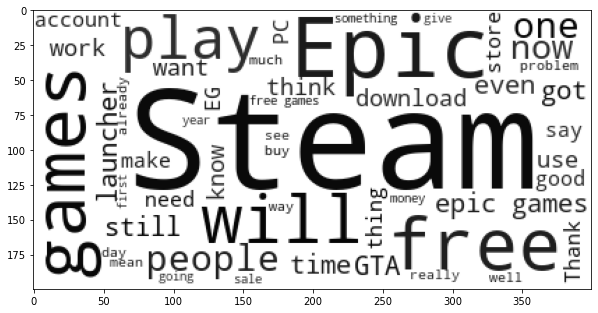

In [15]:
stp = STOPWORDS.copy()
stp.add('game')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

## Sentiment Analysis

- ### __Sentiment Classification using Vader package__

In [16]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#FIRST, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

We can add sentiment scores to words manually if we want

In [18]:
new_words = {
    'Steam' : 0,
    'Epic Games' : 0,
}

sid.lexicon.update(new_words)

In [19]:
sid.polarity_scores('Epic Games Store is better than Steam')

{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}

In [20]:
#As this is for demonstration purposes only - instead of doing the scoring over 200,000+ rows, we will use a subset
df = comments #[comments.Key<101]
df.shape

(34129, 4)

In [21]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [22]:
df[['vdr neg','vdr neu','vdr pos','vdr compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [23]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound
0,"I just did my first purchase from epic , I got...",28.0,2020-05-22 12:37:51,1.0,0.140,0.860,0.000,-0.4168
1,Actually i already bought 3 games on epic : Th...,8.0,2020-05-22 12:45:06,1.0,0.185,0.736,0.079,-0.6369
2,me who got the 80th game for free : ),6.0,2020-05-22 14:11:36,1.0,0.000,0.680,0.320,0.5106


In [24]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound
count,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000
mean,2.661900,337.082510,0.065284,0.790034,0.141019,0.161088
std,6.115684,271.797193,0.119240,0.214182,0.190306,0.447203
min,-46.000000,1.000000,0.000000,0.000000,0.000000,-0.993200
25%,1.000000,111.000000,0.000000,0.694000,0.000000,0.000000
50%,1.000000,263.000000,0.000000,0.828000,0.084000,0.000000
75%,3.000000,527.000000,0.095000,1.000000,0.206000,0.510600
max,216.000000,994.000000,1.000000,1.000000,1.000000,0.999100


- ### Sentiment Classification using Textblob package

In [25]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [26]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [27]:
#As this is for demonstration purposes only - we will only use a subset
df = comments #[comments.Key<101]

In [28]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [29]:
df[['TB Classification','TB pos','TB neg']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

In [30]:
df.head(3)

,Reply,Upvote,Time,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB Classification,TB pos,TB neg
0,"I just did my first purchase from epic , I got...",28.0,2020-05-22 12:37:51,1.0,0.140,0.860,0.000,-0.4168,pos,0.742065,0.257935
1,Actually i already bought 3 games on epic : Th...,8.0,2020-05-22 12:45:06,1.0,0.185,0.736,0.079,-0.6369,pos,0.866839,0.133161
2,me who got the 80th game for free : ),6.0,2020-05-22 14:11:36,1.0,0.000,0.680,0.320,0.5106,neg,0.497501,0.502499


In [31]:
df.describe()

,Upvote,Key,vdr neg,vdr neu,vdr pos,vdr compound,TB pos,TB neg
count,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,34129.000000,3.412900e+04,3.412900e+04
mean,2.661900,337.082510,0.065284,0.790034,0.141019,0.161088,5.690029e-01,4.309971e-01
std,6.115684,271.797193,0.119240,0.214182,0.190306,0.447203,2.683054e-01,2.683054e-01
min,-46.000000,1.000000,0.000000,0.000000,0.000000,-0.993200,1.682455e-07,8.749978e-27
25%,1.000000,111.000000,0.000000,0.694000,0.000000,0.000000,3.879625e-01,2.159847e-01
50%,1.000000,263.000000,0.000000,0.828000,0.084000,0.000000,5.566975e-01,4.433025e-01
75%,3.000000,527.000000,0.095000,1.000000,0.206000,0.510600,7.840153e-01,6.120375e-01
max,216.000000,994.000000,1.000000,1.000000,1.000000,0.999100,1.000000e+00,9.999998e-01


In [32]:
df['TB Classification'].value_counts()

pos    21128
neg    13001
Name: TB Classification, dtype: int64

- ### Sentiment Classification using Self-Trained Classifier Module for Kaggle

In [ ]:
import import_ipynb
%run Kaggle_Trained_Classifier.ipynb

In [ ]:
Z = vectorizer.transform(df['Reply'])

In [ ]:
predicted2 = nb.predict(Z)

In [ ]:
df2 = df

In [ ]:
df2['Classification for Kaggle'] = predicted2

In [ ]:
df2.head()

In [ ]:
predicted2.shape

In [ ]:
df.shape

In [ ]:
df['Classification for Kaggle'].value_counts()

In [ ]:
df2.head(10)

Using the Textblob package, we can see that the Epic Games Store reddit has a mixed sentiment response on posts. 39% bad sentimes and 61% good sentiment.

Using our own trained classification module, there seems to be more Negative sentiments compared to Positive ones. 23% Negative response and 21% Positive sentimes. But if we set aside the Neutral Sentimes, this looks like a very mixed sentiment.

In [ ]:
df['Classification for Kaggle'].value_counts(normalize=True) * 100

In [ ]:
df['Classification'].value_counts(normalize=True) * 100